PSEUDO CODE:

Algorithm: REINFORCE
### step 1 
Initialise parameters: step size 𝛼 ∈ (0,1]

### step 2 
Initialise policy network 𝜋 with parameters 𝜽

## Main loop 
### step 3 
For episode = 1, 𝑀 do

    Generate an episode trajectory 𝜏~𝜋𝜽

### step 4 

    For 𝑡 = 1, 𝑇 − 1 do

       G <- Sum of rewards

       𝜽 <- update parameters

    End For
    
End For (related to episode loop)



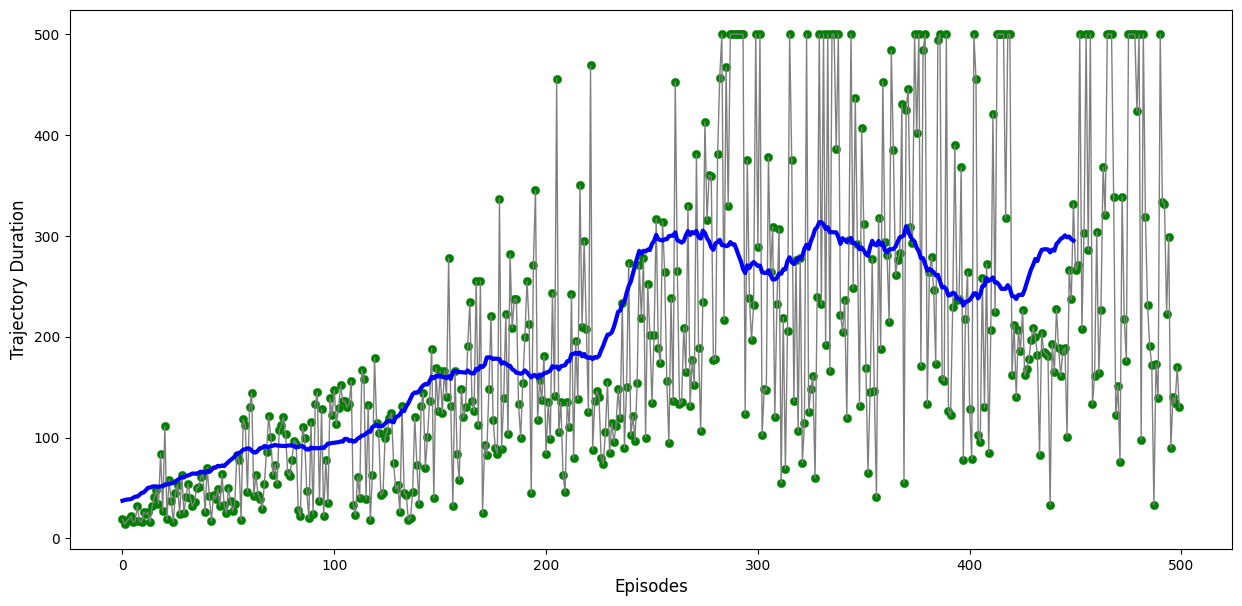

In [172]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import time


    
env = gym.make('CartPole-v0')


#STEP 2: Intialize NN 

obs_size = env.observation_space.shape[0] #Initialize number of observation inputs for NN
action_size = env.action_space.n  #Initialize number of actions for NN
hidden_layer_size = 100
hidden_layer_size2 = 100


model = torch.nn.Sequential(
                    torch.nn.Linear(obs_size, hidden_layer_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_layer_size, hidden_layer_size2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_layer_size2, action_size),
                    torch.nn.Softmax(dim=0)
            )

#STEP 1: Initialize parameters etc.
learning_rate = 0.003 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
TRANSITONS = 500
Episodes = 500 #change to run for longer or shorter
gamma = 0.99
reward = []

#STEP 3: Gain a trajectory of experience 
for trajectory in range(Episodes): # Outer loop for generating trajectories
    curr_state = env.reset()[0] #Get current state
    
    done = False
    transitions = [] # list for transitions 
    
    for t in range(TRANSITONS): # loop to append each transition info into a list. 
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), 
                 p=act_prob.data.numpy())
        prev_state = curr_state
        #print(env.step(action))
        curr_state,_, done,_, info = env.step(action) 
        
        transitions.append((prev_state, action, t+1)) 
        if done: 
            break
    reward.append(len(transitions)) #The length of transitions indicates the total reward for cartpole.
    reward_batch = torch.Tensor([r for (s,a,r) in 
                   transitions]).flip(dims=(0,)) #flip the rewards in order to use discounting loop
    batch_Gvals =[]
    for i in range(len(transitions)): #this double loop discounts the rewards
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
             new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_Gvals.append(new_Gval)

    #STEP 4: Calculate loss and update NN. 
    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    expected_returns_batch /= expected_returns_batch.max() # normalize expected returns 
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 
    pred_batch = model(state_batch) #get the probabilities for the states seen in the episode
    prob_batch = pred_batch.gather(dim=1,index=action_batch #get the probabilities associated with the given action taken for the state
                 .long().view(-1,1)).squeeze() 
    
    loss= -torch.sum(torch.log(prob_batch)*expected_returns_batch) #compute the loss as given by REINFORCE 
    
    optimizer.zero_grad() #clear the gradients in order to provide room for new gradients
    loss.backward() #calculate gradients.
    optimizer.step() #take step in the direction of new gradient.
    

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y
score = np.array(reward)
avg_score = running_mean(score)
plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Episodes",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)
